## 建立问题和设定目标

首先这是一个数据分析的练习项目，我选择了泰坦尼克船客的数据进行分析。

### 提出问题
 是什么因素导致高概率的存活？是否和性别，年龄，船舱级别或者其他任何因素有关？
 如果回答这个问题，我们将从**性别，年龄，船舱级别，兄弟姐妹个数，父母或者还在在船个数来计算，最后乘客票的花费**。

## 数据加工和数据探索

### - 数据获取和数据概览
本案例分析的所有数据来自[Kaggle 网站](https://www.kaggle.com/c/titanic/data), 该网站对数据的说明如下：

    Variable	Definition	Key
    - survival	Survival	0 = No, 1 = Yes
    - pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    - sex	    Sex	
    - Age	    Age in years	
    - sibsp	# of siblings / spouses aboard the Titanic	
    - parch	# of parents / children aboard the Titanic	
    - ticket	Ticket number	
    - fare	Passenger fare	
    - cabin	Cabin number	
    - embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [220]:
##导入各种数据分析和画图模块
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#use read_csv() to get all data
file_name = 'train.csv'
titanic_df = pd.read_csv(file_name)

print titanic_df.describe()
print titanic_df.head()


       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
   PassengerId  Survived  Pclass  \
0            1         0       3   
1        

从上面的信息看，总共有891个记录，或者说有891个乘客。另外发现Age数据不全，总共才714个记录，另外Cabin和Embarked数据也不全，我们需要想办法补充这部分数据。

In [221]:
print titanic_df.groupby(['Survived']).size()
total_no_survived_num = titanic_df.groupby(['Survived']).size()[0]
total_survived_num = titanic_df.groupby(['Survived']).size()[1]

Survived
0    549
1    342
dtype: int64


在当前这份训练数据里面，现这891个乘客到底只有342人生还，549人丧生，整体存活率是38%，死亡率是62%，具体哪些因素和死亡率有关，我们需要一步步来进行数据分析。

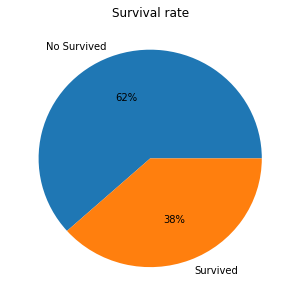

In [222]:
plt.figure(figsize = (5,5))
plt.pie([total_no_survived_num, total_survived_num],labels=['No Survived','Survived'],autopct='%1.00f%%')
plt.title('Survival rate') 
plt.show()

### - 数据探索
#### - 性别

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
dtype: int64


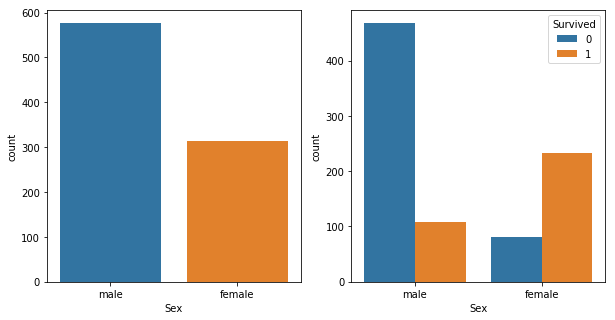

In [223]:
#尝试用sns画图，分析不同性别的比例和不同性别的生还比例
print titanic_df.groupby(['Sex','Survived']).size()

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5)) 
sns.countplot(x='Sex',data=titanic_df,ax=axis1)
#用Sex做横轴，看一下Survived的数据
sns.countplot(x='Sex',data=titanic_df,hue="Survived",ax=axis2)

从上图我们可以明显看出男性存活的总数几乎死亡的1/4，而女性存活的数目差不多是死亡人数的一倍多。这个反映了当时的社会还是非常文明，当遇到危险或者灾难的时候，男人们比较绅士，女人先走，先救女人，女人获得了比男性几倍的生还几率。
我们再看看到底男性和女性的生还比例到底是多少？

In [224]:
#女性的生还比例
total_female_survived = titanic_df.groupby(['Sex','Survived']).size()[1]
total_female_dead = titanic_df.groupby(['Sex','Survived']).size()[0]
female_survived_rate = float(total_female_survived)/(total_female_dead+total_female_survived)
print "女性的生还比例：%f" %female_survived_rate

#男性的生还比例
total_male_survived = titanic_df.groupby(['Sex','Survived']).size()[3]
total_male_dead = titanic_df.groupby(['Sex','Survived']).size()[2]
male_survived_rate = float(total_male_survived)/(total_male_dead+total_male_survived)
print "男性的生还比例：%f" %male_survived_rate

女性的生还比例：0.742038
男性的生还比例：0.188908


正如前面图所示，女性的生坏比例比男性高4倍还多。那么还有哪些方面我们可以继续挖掘一些，下面我们将分别从年龄/船舱级别/是否有兄弟姐妹/出发港口分别来看看生还比例。

####   - 年龄
年龄的数据看，一方面0.42岁到80岁不等，按照这个划分太细，得不出什么结论，因此下面将年龄划分几个部分来看看：
- 0～12岁：儿童；
- 13～18岁：青少年，基本上未婚；
- 19～59岁，成年，行为完全可以自理，有的可能已经有孩子，具有责任感；
- 60岁到80岁：老年，可能有孙子了，可能老伴已经离开了。

In [225]:
#先看一下当前年龄相关的统计数据
print titanic_clean_df.describe()['Age']

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


有年龄纪录的数目是714, 丢失了177
Age_level
Adult     0.388788
Child     0.579710
Senior    0.227273
Teen      0.428571
Name: Survived, dtype: float64


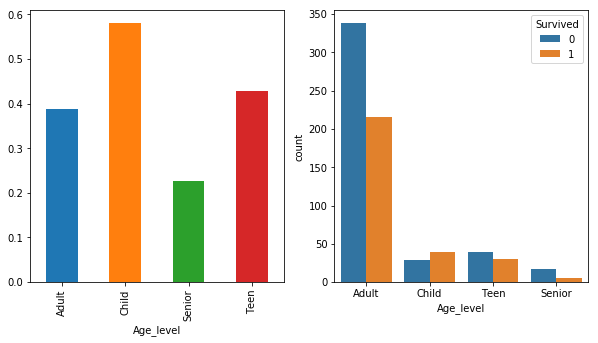

In [226]:
##在开始之前，我们先删除原始数据中没有用的信息，比如PassengerId, Name, Ticket
titanic_clean_df = gender_submission.drop(['PassengerId','Name','Ticket'], axis=1)
total_age_count = titanic_clean_df['Age'].count()
total_age_missed = titanic_clean_df['Survived'].count()-total_age_count
print "有年龄纪录的数目是%d, 丢失了%d" %(total_age_count,total_age_missed)

## 按照上面的划分对数据进行初步加工,每个年龄阶段的所占比例，总数
def change_age_category(age):
    if age<=12:
        return 'Child'
    elif (age <= 18 and age > 12):
        return 'Teen'
    elif (age <= 60 and age > 18):
        return 'Adult'
    elif (age>60):
        return 'Senior'
## 增加Age_level字段
titanic_clean_df['Age_level'] =  titanic_clean_df['Age'].apply(change_age_category)

## 画出不同年龄段人员的存活比例。
by_age = titanic_clean_df.groupby('Age_level')['Survived'].mean()
print by_age

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5)) 
by_age.plot(kind='bar', ax=axis1)

## 画出不同年龄段人员的存活和死亡对比，更加有参照性
sns.countplot('Age_level',data=titanic_clean_df,hue="Survived",ax=axis2)


观察：
- 从上图可以看到，child存活下来的人多于死于灾难的人；
- Teen虽然存活下来的人数少一些，也差不多很接近；
- Adult存活下来的人要比灾难中死去的人少将近1/3；
- 老人的存活比例很低，可以说只有1/3不到。

2）上图是有年龄的人员在714个记录下的情况，如果我们把没有年龄信息的人员补充进来，可以再看看这个存活比例。补充年龄的方法有好几种，都不是很完美：
- 按照以上划分求出不同年龄段的比例，假定人员年龄丢失的信息是按照这个比例，但是也有可能不是按照这个比例;
- 按照当前均值来在一定范围补充随机值，原则上不改变最终年龄的均值。

为了方便起见我们采用了第二种方式来补充年龄数据。

In [227]:
## 补充177个随机年龄到该矩阵来
## 求年龄随机数，范围在 (mean - 2std， mean + 2std)
average_age_titanic = titanic_clean_df.describe()['Age'][1]
std_age_titanic = titanic_clean_df.describe()['Age'][2]
rand_age = np.random.randint(average_age_titanic - 2*std_age_titanic, average_age_titanic + 2*std_age_titanic, size = total_age_missed)

## 把NAN替换
titanic_clean_df["Age"][np.isnan(titanic_clean_df["Age"])] = rand_age

## 之后我们再看一下统计数据
print titanic_clean_df.describe()['Age']


count    891.000000
mean      29.773479
std       14.812861
min        0.000000
25%       20.000000
50%       28.000000
75%       39.000000
max       80.000000
Name: Age, dtype: float64


/Users/gaochuang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


确实的年龄数据补全了，平均值和方差没有太大变化，这时候我们再来看一下不同年龄阶段的生存率，是否有不一样的结果？

Age_level
Adult     0.388788
Child     0.579710
Senior    0.227273
Teen      0.428571
Name: Survived, dtype: float64


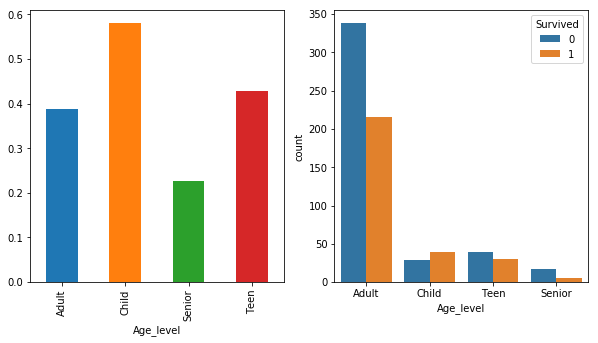

In [228]:
## 对添加missed人进行人群划分
def add_missed_age_category(passenger):
    age, age_level = passenger
    if age_level =="":
        age_level = change_age_category(age)

titanic_clean_df[["Age","Age_level"]].apply(add_missed_age_category, axis=1)
by_age_new = titanic_clean_df.groupby('Age_level')['Survived'].mean()
print by_age_new

## 画出不同年龄段人员的存活比例
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5)) 
by_age.plot(kind = "bar", ax=axis1)

## 画出不同年龄段人员的存活和死亡对比，更加有参照性
sns.countplot(x='Age_level',data=titanic_clean_df, hue="Survived", ax=axis2)

In [229]:
## 最终打出不同年龄段的生还率
print "Child（0～12）的存活率是 %f" %(by_age_new['Child'])
print "Teen (12~18) 的存活率是 %f" %(by_age_new['Teen'])
print "Adult (19~59) 的存活率是 %f" %(by_age_new['Adult'])
print "Senior (60岁以上) 的存活率是 %f" %(by_age_new['Senior'])

Child（0～12）的存活率是 0.579710
Teen (12~18) 的存活率是 0.428571
Adult (19~59) 的存活率是 0.388788
Senior (60岁以上) 的存活率是 0.227273


补充完数据再看看每个年龄段的存活率，基本没有改变，Child的存活率最高，超过50%，接下来是Teen接近50%，成年人的存活率排第三，是38.9%,老年人的存活率最小，才22.7%。

因此我们可以猜测，在灾难发生的时候，小孩获得了更多的生还机会，受到了大家的保护，有些成年人把自己的生还机会让给了孩子。
60岁上的老人可能是求生欲望不强，在灾难发生后无论是体力还是心力都不是很强，存活的几率不高。

####  - 船舱等级的分析

In [230]:
#先看一下当前船舱相关的统计数据
print titanic_clean_df['Pclass'].value_counts()
by_pclass = titanic_clean_df.groupby('Pclass')['Survived'].mean()
print by_pclass

3    491
1    216
2    184
Name: Pclass, dtype: int64
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


1级船舱的存活率是： 0.629630
2级船舱的存活率是： 0.472826
3级船舱的存活率是： 0.242363


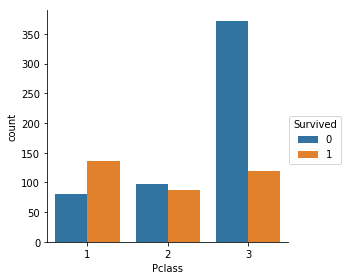

In [231]:
## 我们来画图，看看不同级别的生存数目和死亡人数之间的对比
sns.factorplot('Pclass',data=titanic_clean_df,kind="count",hue="Survived") 

## 打印出不同船舱的存活率
print "1级船舱的存活率是： %f" %(by_pclass[1])
print "2级船舱的存活率是： %f" %(by_pclass[2])
print "3级船舱的存活率是： %f" %(by_pclass[3])

观察：
无论从数据上还是看图，我们都发现1级船舱的存活率非常高，为63%，二级船舱的存活率次之，也有47%，三级船舱存活率才24%，非常低。
这也说明有钱人还是收到了更多照顾，也有可能一级船舱在船的上层，发生灾难的时候他们更容易逃离，即使排队获得救生艇的机会比下层船舱的乘客。

#### - 兄弟姐妹

In [232]:
#先看一下当前兄弟姐妹相关的统计数据
print titanic_clean_df['SibSp'].value_counts()
by_SibSp = titanic_clean_df.groupby('SibSp')['Survived'].mean()
print by_SibSp

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64


从数据上看，孤独一个人的乘客占大多数，有608个；而有1个次之，209个，或者2个兄弟姐妹的人为28个，逐渐越来越少。
从存活率上来看有一个兄弟姐们在船上的人存活率最高，超过一半，为53.59%；
有2个兄弟姐们在船上的人存活率接近一半，为第二，为46.42%；
人数最多的，孤独一个人的乘客只有1/3多一点，为34.53%；
其他都比较差。
我们来画图，这样更直观一些。

Text(0.5,1,u'The Survived rate by Siblings')

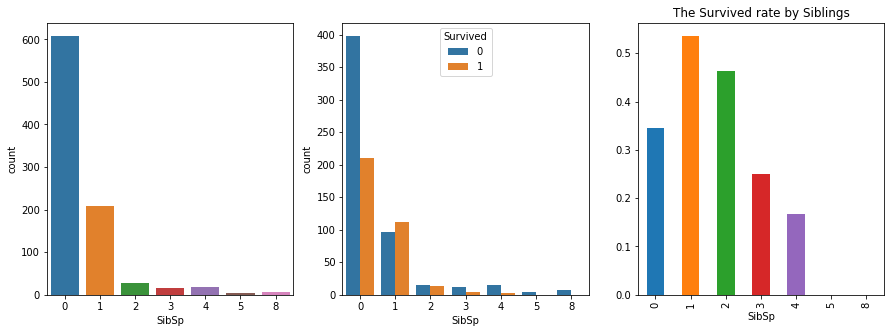

In [233]:
## 先画出根据兄弟姐们个数分类的人数对比柱状图
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5)) 
sns.countplot(x='SibSp',data=titanic_clean_df,ax=axis1)
plt.title('Total counts by siblings')

## 再画出根据兄弟姐们个数分类的总人数和存活人数对比图
sns.countplot(x='SibSp',data=titanic_clean_df,hue="Survived",ax=axis2)
plt.title('Total counts Vs Survived by siblings')

## 最后我们画出根据兄弟姐们个数分类后的存活率
by_SibSp.plot(kind = "bar",ax=axis3)
plt.title('The Survived rate by Siblings')

#### - 父母或者孩子在船舱个数

In [234]:
#先看一下当前父母孩子们个数相关的统计数据
print titanic_clean_df['Parch'].value_counts()
by_Parch = titanic_clean_df.groupby('Parch')['Survived'].mean()
print by_Parch

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64
Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64


**观察：**
1. 人员占比
    - 没有父母或者孩子在船舱的人最多，678个和上面兄弟姐们的数据几乎是一致的，占76%；
    - 其次是有一个在船上，或者父子两人，父女两人，或者母子两人，或者母女两人，他们差不多有118人，占总人数的13%
    - 有两个在船上80人，占9.0%左右；
    - 剩下加起来1%～2%，从统计学的角度看，样本量太少，可以忽略不计。
2. 存活率比较：
    - 有3个孩子或者父母孩子加起来是4个的在船上的存活率最高，差不多60%，但是样本量太少，先暂时忽略；
    - 有一个或者2个存活率很接近，都超过了50%，这个数据还是很能说明问题；
    - 没有孩子在船上的,存活率很低，1/3强，34.36%。
因此可以看到有孩子的比没有孩子在船上的存活率要高，是不是因为孩子在船上，必须要想办法寻找各种办法让孩子活下去，也符合我们之前的发现，孩子的存活率高的观察。
下面我们画图来观察一下。

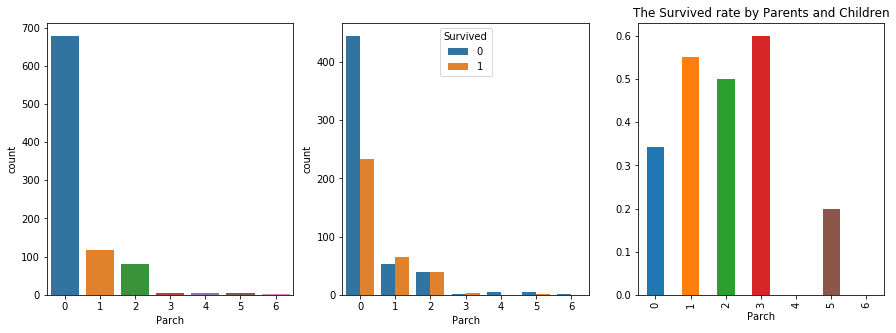

In [235]:
## 先画出根据父母孩子们个数分类的人数对比柱状图
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5)) 
sns.countplot(x='Parch',data=titanic_clean_df,ax=axis1)

## 再画出根据父母孩子们个数分类的总人数和存活人数对比图
sns.countplot(x='Parch',data=titanic_clean_df,ax=axis2,hue="Survived")

## 最后我们画出根据父母孩子们个数分类后的存活率
by_Parch.plot(kind = "bar")
plt.title('The Survived rate by Parents and Children')

plt.show()

#### - 乘客票务花费

In [236]:
#先看一下当前父母孩子们个数相关的统计数据
print titanic_clean_df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


从统计数据来看，std比mean还大，说明这个数据比较分散，不能用上面的方法进行分类进行分析。其实票务花费应该和船舱级别是挂钩的，我们看看他们之间有什么关系。

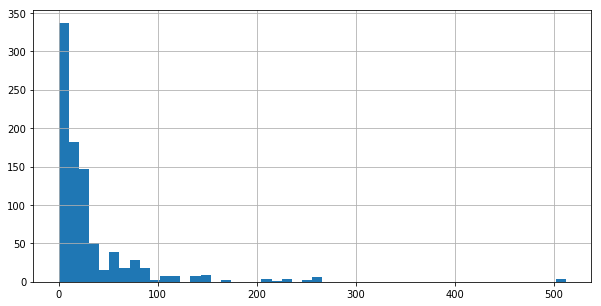

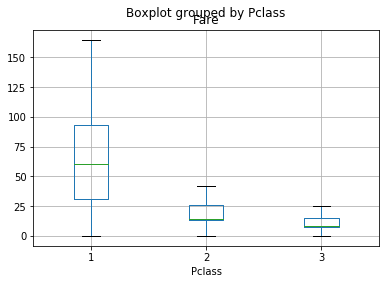

In [237]:
##看看船票费用的分布
plt.figure(figsize=(10,5))
titanic_clean_df['Fare'].hist(bins = 50)

##画出船票费用和船舱级别的关系
titanic_clean_df.boxplot(column='Fare', by='Pclass', showfliers=False)
plt.show()

从上面两张图可以可以看到，很多人套了很少的钱上船，不到20，2级和3级船舱的船票集中在25英镑以下。
另外，目前还看不到票价和存活率有什么关系？下面我们继续挖掘。

Survived
0    22.117887
1    48.395408
Name: Fare, dtype: float64


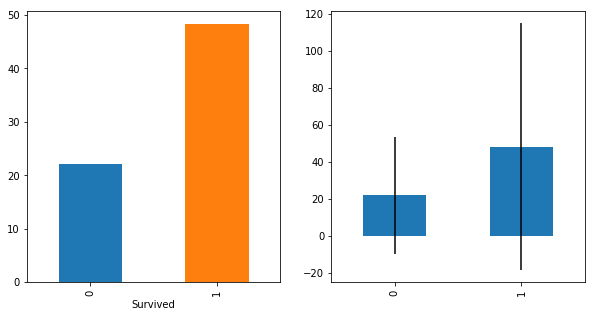

In [238]:
by_Fare = titanic_clean_df.groupby('Survived')['Fare'].mean()
print by_Fare

##开始画图，先画一下生死两种人的平均船票价格
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5)) 
by_Fare.plot(kind='bar', ax=axis1)

## 由于船票价格浮动太大，我们在用统计学的工具来看看，生死两种人大概的船票价格区间
fare_not_survived = titanic_clean_df["Fare"][titanic_clean_df["Survived"] == 0]
fare_survived     = titanic_clean_df["Fare"][titanic_clean_df["Survived"] == 1]

avgerage_fare = pd.DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = pd.DataFrame([fare_not_survived.std(), fare_survived.std()])
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False, ax=axis2)

plt.show()

**观察：**
无论是从均值还是船票区间来看，存活下来的人的船票价格要高于死去的人，他们的船票价格在0到55之间，而死去的大部分在20以下。如果和船舱级别挂钩的话，由于船票价格低，大部分人在2级和3级船舱，而掏更多钱买票的人基本在1级船舱，他们的存活率因此比较高。


### 分析总结

总结分为两个部分，分别是本次数据分析得出的规律和对于分析的限制性进行讨论。

#### - 数据分析总结

本次分析主要探寻泰坦尼克号上的生还率和各因素：性别、年龄、客舱等级、兄弟姐妹个数、父母孩子个数、船票价格的关系。

样本数量为 891，海难发生后，生还者还剩 342 人，生还率为： **38%**。

**性别**：
在891人中，男性共577人，女性314人，男女比例为 65% 和 35%。海难发生后，男性存活了109人，女性为233人，男女比例变为 32% 和 68%。男性生还率仅为**19%**，女性生还率为 **74%**，远远高于男性的 19%。可见女性比男性在这次事故中更容易生还，表明“女士优先”的原则在本次事故中得到了发扬。

**年龄**：
    - 在891人当中，有年龄数据记录总共是714，缺失了177条记录，平均年龄约为 30 岁， 标准差 15 岁。
    - 年龄分布太散，从0.42到85岁，因此我们把此数据做了加工，一方面补充众数，一方面重新划分了四个年龄段：小孩（12岁以下），青少年（12岁到18岁），成年（19岁到60岁）和老年（60岁以上）；
    - 按照此年龄划分，我们发现儿童的成活率最高，为**58%**，接下来是青少年为**423%**，老年人最低才**23%**
   以上我们可以推断出，当事故发生的时候，绝大多数人还是听从船长的指挥和号召：让女人和孩子先走，另外也反映了当时社会的文明程度。
   
**船舱等级**：
泰坦尼克号上有三种船舱类型。海难发生前，一等舱有 216 人，二等舱 184 人，三等舱 491 人，分别占总人数的 24%， 21%， 55%。海难发生后，一等舱、二等舱、三等舱的乘客人数变为136、87、119人，分别占总人数的 40%, 25%, 35%。一等舱生还率为 63%，二等舱为 47%，三等舱为 24%。可见客舱等级越高，生还率越高。

**兄弟姐妹个数**：
    - 孤独一个人的乘客占大多数，有608个；而有1个次之，209个，或者2个兄弟姐妹的人为28个，逐渐越来越少。 
    - 从存活率上来看有一个兄弟姐们在船上的人存活率最高，超过一半，为53.59%； 有2个兄弟姐们在船上的人存活率接近一半，为第二，为46.42%；
    - 人数最多的，孤独一个人的乘客只有1/3多一点，为34.53%； 其他都比较差。
总之，有兄弟姐妹的乘客的生还几率要高于孤独乘客，这里面具体人文原因需要进一步挖掘和探索。

**父母和子女同乘**
    - 没有父母或者孩子在船舱的人最多，678个和上面兄弟姐们的孤独数据几乎是一致的，占76%；
    - 但是没有父母子女同船的乘客，仅生还 233 人，生还率为 34%。
    - 而有父母或子女同船的乘客都超过了50%，尤其是有3个的，都快到了60%。
因此，有父母或者子女同乘的生还率要远高于孤独乘客。

**票价**
    - 一方面票价的分布也比较散，和船舱级别有一定的关联度，2级和3级船舱的票价集中在25以下；
    - 另外一方面，生还下来的人他们的船票价格要高于死去的乘客，无论从均值还是区间范围。
因此，可以推测票价和船舱级别挂钩，由于船票价格低，大部分人在2级和3级船舱，而掏更多钱买票的人基本在1级船舱，他们的存活率因此比较高。


#### 分析限制讨论

此数据并非全部乘客的数据，据了解，泰坦尼克号上共有乘客 2224 人，而本数据集共有 891 人。
    - 如果该数据集是从 2224 人中随机选出，根据中心极限定理，该样本也足够大，分析结果有代表性；
    - 如果不是随机选出，那么分析结果就不可靠了。

另外此分析忽略了cabin船舱号和离岸港口，姓名的分析，一方面是cabin的数据很少不全，另外一方面这些分析要结合船舱结构、历史和地理知识，由于本人对这部分不是很熟悉，担心解释不了分析结果，其实分析的路子是一样的。
因此可能还有其他因素影响生还情况，还可以继续寻找数据继续探索。

### 参考文献
- [seaborn 官方文档 ](http://seaborn.pydata.org)
- [pandas 官方文档](http://pandas.pydata.org)
- [泰坦尼克号乘客生存分析——用机器学习告诉你，如果你在当时的船上，有多大机率生还？](https://www.jianshu.com/p/9a5bce0de13f?utm_campaign=maleskine&utm_content=note&utm_medium=seo_notes&utm_source=recommendation)
- [python数据分析实战之泰坦尼克号统计](http://blog.51cto.com/youerning/1711371)
    